# Data Preparation (Time Series processing)

In [13]:
import os
import numpy as np
data_dir = 'jena_climate/'
fname = os.path.join(data_dir,'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines),len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:]= values
float_data.shape

(420551, 14)

In [9]:
import matplotlib.pyplot as plt

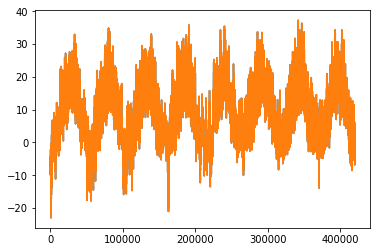

In [11]:
temp = float_data[:,1]
plt.plot(range(len(temp)),temp)
plt.show()

In [18]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std


In [17]:
def generator(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),lookback // step,data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [21]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,lookback=lookback,delay=delay,min_index=0,max_index=200000,shuffle=True,
step=step,batch_size=batch_size)

val_gen = generator(float_data,lookback=lookback,delay=delay,min_index=200001,max_index=300000,step=step,
batch_size=batch_size)

test_gen = generator(float_data,lookback=lookback,delay=delay,min_index=300001,max_index=None,step=step,
batch_size=batch_size)

val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

# Traditional ML-Model

In [25]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=1,
                              validation_data=val_gen,validation_steps=val_steps)

Epoch 1/1
500/500 [==============================] - 417s 834ms/step - loss: 1.1562 - val_loss: 0.4916


# GRU Model

In [27]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=1,validation_data=val_gen,validation_steps=val_steps)

Epoch 1/1
500/500 [==============================] - 1912s 4s/step - loss: 0.3049 - val_loss: 0.2732


# Bidirectional GRU 

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=1,validation_data=val_gen,validation_steps=val_steps)

Epoch 1/1
499/500 [============================>.] - ETA: 0s - loss: 0.2969